# Предисловие

В этом блокноте я обучу WGAN для генерации человечских лиц на основе датасета CelebA Faces в разрешении 64х64

## Импорт необходимых библиотек

In [1]:
import os
import torch
import numpy as np
import torchvision.transforms as tt
from torch import nn
from torch.utils.data import  DataLoader, Dataset, ConcatDataset
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets import DatasetFolder
from collections import Counter
from PIL import Image

## Кастомный датасет для загрузки изображений

Создание кастомного класса для загрузки и обработки изображений из указанной директории.


В этом блоке применяются трансформации к картинкам, а также создается дополнительная часть датасета с аугментациями, что увеличивает нашу выборку

In [2]:
class CustomDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.images = os.listdir(root)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root, self.images[idx])
        image = Image.open(img_name).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image


train_path = '/kaggle/input/celeba-small-images-dataset/training'
test_path = '/kaggle/input/celeba-small-images-dataset/testing'
val_path = '/kaggle/input/celeba-small-images-dataset/validation'


trans = tt.Compose([
    tt.Resize(size=(64, 64)),
    tt.ToTensor(),
    tt.Normalize(mean=[0.516, 0.415, 0.362], std=[0.259, 0.231, 0.224])
])
aug_trans=tt.Compose([
    tt.Resize(size=(64, 64)),
    tt.RandomHorizontalFlip(),
    tt.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.2),
    tt.ToTensor(),
    tt.Normalize(mean=[0.516, 0.415, 0.362], std=[0.259, 0.231, 0.224])
])


train_dataset = CustomDataset(root=train_path, transform=trans)
train_aug_dataset = CustomDataset(root=train_path, transform=trans)
test_dataset = CustomDataset(root=test_path, transform=trans)
val_dataset = CustomDataset(root=val_path, transform=trans)

## Объединение датасетов в один даталоадер

Так как изначально датасет был разбит на выборки, но такое разделение для нашей задачи не нужно, мы просто объединяем их для увеличения количества исходных данных

In [3]:
batch_size = 128

full_dataset = ConcatDataset([train_dataset, test_dataset, val_dataset])

loader = DataLoader(full_dataset, batch_size=batch_size, shuffle=True)

In [4]:
print(f"The size of the dataloader {len(loader)} batches of {batch_size}")

The size of the dataloader 1583 batches of 128


Для наглядности выведем размерность картинок

In [5]:
img_sample= next(iter(loader))
img_sample.shape

torch.Size([128, 3, 64, 64])

И для примера выведем несколько картинок из обучающей выборки

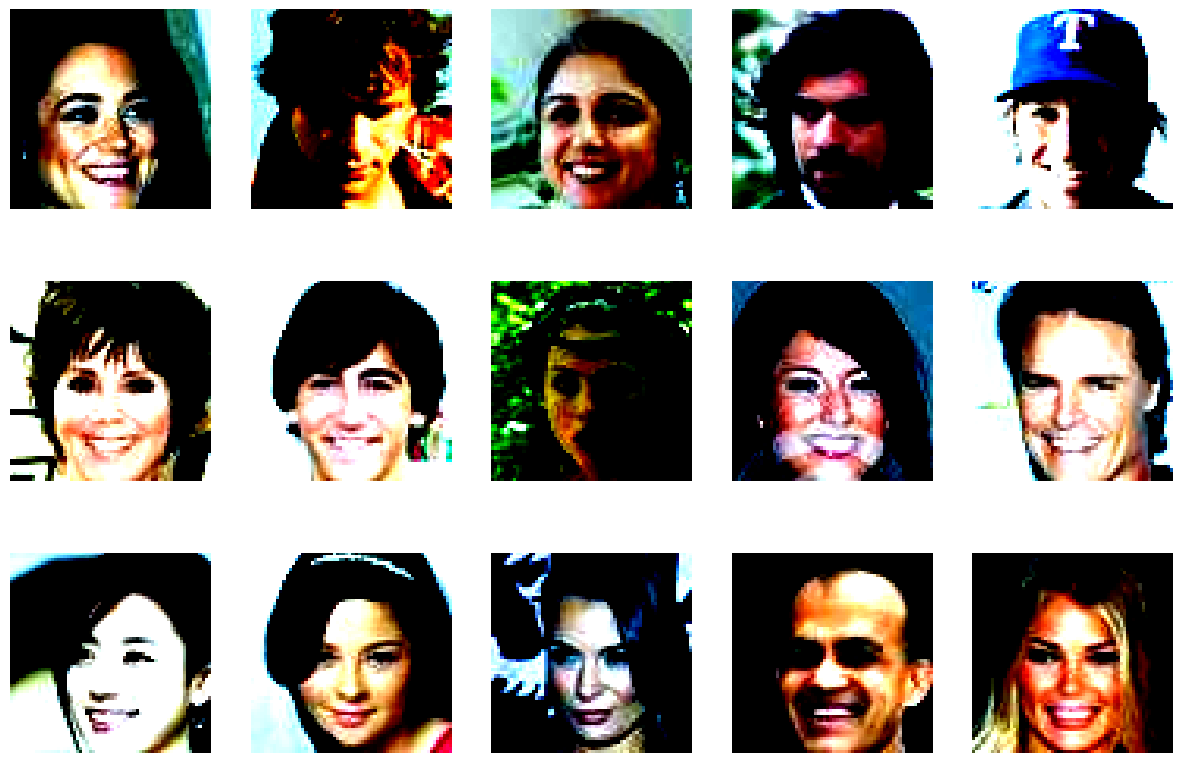

In [6]:
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    img = img_sample[i].numpy()
    img = np.transpose(img, (1, 2, 0))
    ax.imshow(img)
    ax.axis('off')

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Класс генератора

 **Описание**: 
 Класс `Generator` определяет архитектуру генератора для WGAN. Генератор преобразует шум в изображения через последовательные блоки транспонированных сверточных слоев.
 
 
 **Почему выбран WGAN**: В отличие от обычного GAN, WGAN использует расстояние Вассерштейна, что делает обучение более стабильным и избавляет от проблемы "затухающих градиентов". Это особенно полезно при генерации изображений, где традиционные GAN могут быть нестабильны.
 
 
 **Преимущества**: Улучшенная стабильность и качество генерируемых изображений.
 
 **Недостатки**: Требуется больше вычислительных ресурсов для вычисления градиентной штрафной функции.

In [8]:
class Generator(nn.Module) : 
    def __init__(self , hidden_dim , z_dim) : 
        super().__init__() 
        self.block = nn.Sequential(
            nn.ConvTranspose2d(
                    z_dim , 
                    hidden_dim*8 , 
                    kernel_size = 4, 
                    stride = 1 ,
                    padding = 0 , 
                    bias = False
                ) ,
            nn.BatchNorm2d(hidden_dim * 8) , 
            nn.ReLU(inplace = True) , 
            self.gen_block(hidden_dim * 8 , hidden_dim * 4) ,
            self.gen_block(hidden_dim * 4 , hidden_dim * 2) , 
            self.gen_block(hidden_dim * 2 , hidden_dim) , 
            self.gen_block(hidden_dim , 3 , final_layer=True)
        )
    
        
    def gen_block(self, input_channels, output_channels, kernel_size=4, stride=2, padding = 1 , final_layer=False) : 
        if not final_layer : 
            return nn.Sequential(
                nn.ConvTranspose2d(
                    input_channels , 
                    output_channels , 
                    kernel_size = kernel_size , 
                    stride = stride ,
                    padding = padding ,
                    bias = False
                ) , 
                nn.BatchNorm2d(output_channels) , 
                nn.ReLU(inplace = True)
            )
        
        else : 
            return nn.Sequential(
                nn.ConvTranspose2d(
                    input_channels , 
                    output_channels , 
                    kernel_size = kernel_size , 
                    stride = stride ,
                    padding = padding , 
                    bias = False
                ) ,
                nn.Tanh()
            )
        
        
    def forward(self , noise) :
        x = self.block(noise) 
        
        return x

## Класс Дискриминатора

 **Описание**: 
 Дискриминатор принимает изображения (реальные или сгенерированные) и вычисляет вероятность того, что они настоящие. Архитектура включает сверточные слои с пэддингом и активацией `LeakyReLU`.
 
 **Преимущества**: Использование `LeakyReLU` предотвращает проблему "vanishing gradient" в дискриминаторе, улучшая стабильность обучения.
 
 **Недостатки**: Хотя дискриминатор может стать слишком мощным, его влияние компенсируется регуляризацией через градиентный штраф.

In [9]:
class Discriminator(nn.Module):
    def __init__(self, hidden_dim, in_channels = 3):
        super().__init__()
        self.block = nn.Sequential(
            self.dics_block(in_channels , hidden_dim) , 
            self.dics_block(hidden_dim , hidden_dim*2) , 
            self.dics_block(hidden_dim*2 , hidden_dim*4) , 
            self.dics_block(hidden_dim*4 , hidden_dim*8) , 
            self.dics_block(hidden_dim*8 , 1 , final_layer=True) , 
            nn.Flatten() , 
        )
        
        
    def dics_block(self, input_channels, output_channels, kernel_size=4, final_layer=False) : 
        if not final_layer : 
            return nn.Sequential(
                nn.Conv2d(
                    input_channels , 
                    output_channels , 
                    kernel_size = kernel_size , 
                    stride = 2 , 
                    padding = 1 , 
                    bias = False
                ) , 
                nn.BatchNorm2d(output_channels) , 
                nn.LeakyReLU(0.2 , inplace = True)
            )
        
        else : 
            return nn.Sequential(
                nn.Conv2d(
                    input_channels , 
                    output_channels , 
                    kernel_size = kernel_size , 
                    stride = 1 , 
                    padding = 0 , 
                    bias = False
                )
            )
        
        
    def forward(self , image) : 
        disc_pred = self.block(image) 
        
        return disc_pred

## Функция для генерации шума

In [10]:
def get_noise(n_samples , z_dim) : 
    return torch.randn(n_samples , z_dim , 1 , 1).to(device)

## Установка гиперпараметров

 **Описание**: 
 Здесь определяются ключевые гиперпараметры для обучения модели:
 
 - `z_dim`: размерность входного шума для генератора.
 
 - `hidden_dim`: размер скрытых слоев для генератора и дискриминатора.
 
 - `lr`: скорость обучения для оптимизаторов.
 
 - `crit_iters`: количество итераций обучения дискриминатора перед обновлением генератора.
 
 - `c_lambda`: коэффициент для градиентного штрафа.
 
 - `epochs`: количество эпох обучения.

In [46]:
z_dim = 128
hidden_dim = 64
lr = 0.0001
crit_iters = 5
c_lambda = 10
epochs = 50

Переносим модели на GPU

In [12]:
generator = Generator(hidden_dim, z_dim).to(device)
discriminator = Discriminator(hidden_dim).to(device)

In [13]:
gen_optimizer = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

 **Описание**: 
 
 Оптимизаторы Adam используются для генератора и дискриминатора с одинаковой скоростью обучения и параметрами `betas`. 
 
 **Почему выбран Adam**: Этот оптимизатор подходит для GAN, так как он эффективно справляется с задачами с шумными градиентами, поддерживая стабильность обучения.

## Функция для отображения изображений


In [14]:
def show_tensor_images(image_tensor, num_images=25):

    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

Эта функция принимает тензор изображений, преобразует его из диапазона значений [-1, 1] в [0, 1] и отображает изображения с помощью matplotlib. Благодаря ей можно визуально отслеживать процесс обучения и более точно настраивать гиперпараметры

## Функция для вычисления градиентного штрафа

 Функция вычисляет градиентный штраф для дискриминатора с использованием смешанных изображений. Это один из ключевых элементов в WGAN-GP, который обеспечивает стабильность обучения.
 
 Преимущества: Градиентный штраф помогает избежать проблемы "mode collapse" и делает обучение более устойчивым, особенно при генерации изображений.


In [15]:
def gradient_penalty(crit , real , fake , epsilon) : 
    mixed_images = real * epsilon + fake * (1 - epsilon)
    
    mixed_scores = crit(mixed_images) 
    
    gradient = torch.autograd.grad(
        inputs = mixed_images , 
        outputs = mixed_scores , 
        grad_outputs = torch.ones_like(mixed_scores) , 
        create_graph=True,
        retain_graph=True,
    )[0]
    
    gradient = gradient.view(gradient.shape[0] , -1) 
    
    gradient_norm = gradient.norm(2 , dim=1)
    
    penalty = torch.mean((gradient_norm - 1 )**2)
    
    return penalty

Загружаем сохранённую модель. Обучить за одну сессию достаточно качественно не получалось, поэтому приходилось сохранять версии в процессе

In [16]:
generator.load_state_dict(torch.load('/kaggle/input/generator4/pytorch/default/11/generator_epoch4 (3).pth'))
discriminator.load_state_dict(torch.load('/kaggle/input/discriminator4/pytorch/default/11/discriminator_epoch4 (3).pth'))

<All keys matched successfully>

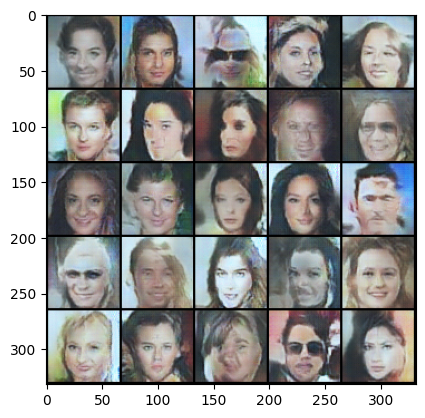

In [45]:
from torchvision.utils import make_grid
fake_noise = get_noise(128, z_dim)
fake = generator(fake_noise)
show_tensor_images(fake)

# Цикл обучения

 **Описание**:
 
 Это основной цикл обучения модели, который проходит по всем эпохам и батчам. На каждом шаге:
 
 - Сначала обновляется дискриминатор: вычисляется потеря для реальных и сгенерированных изображений, а также добавляется градиентный штраф.
 
 - Затем через каждые `crit_iters` итераций обновляется генератор.
 
 - Регулярно выводятся промежуточные сгенерированные изображения для визуализации прогресса.
 
 - После каждой эпохи модели сохраняются для последующего использования.
 
 Преимущества: Такой цикл поддерживает равновесие между обучением дискриминатора и генератора, что является ключевым для стабилизации процесса генерации.
 
 Недостатки: Из-за вычисления градиентного штрафа процесс обучения может быть медленнее по сравнению с обычными GAN.

  0%|          | 0/1583 [00:00<?, ?it/s]

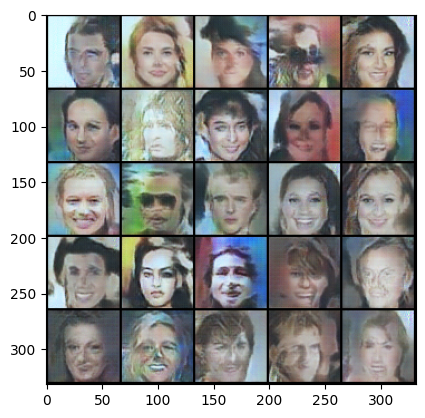

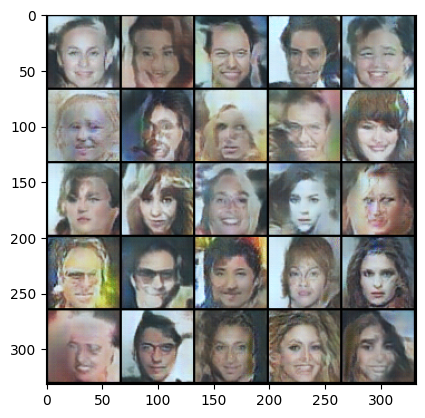

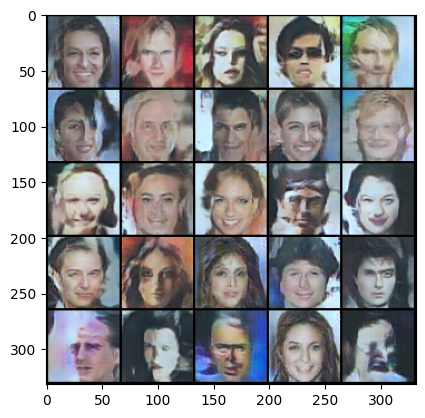

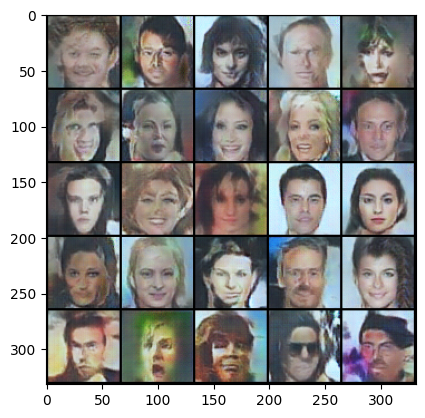

[Epoch 1/10] [Disc loss: -1376.5419921875] [Gen loss: 76161.25]


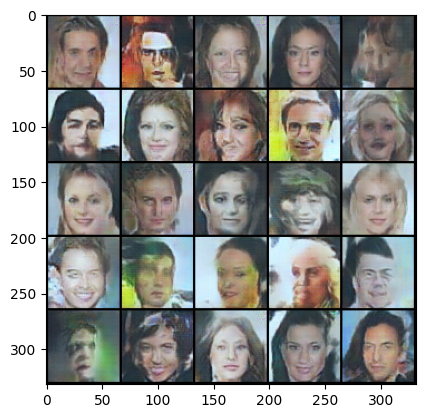

  0%|          | 0/1583 [00:00<?, ?it/s]

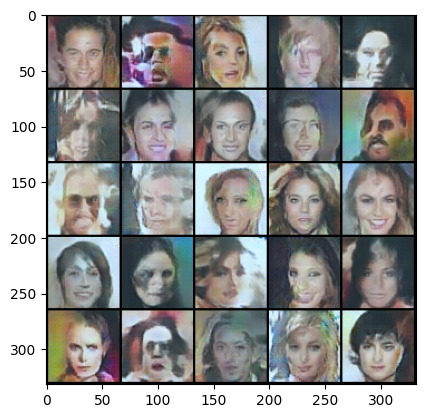

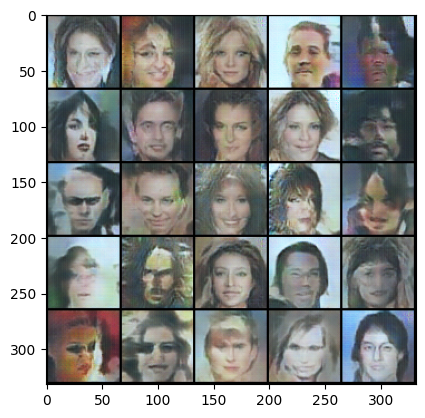

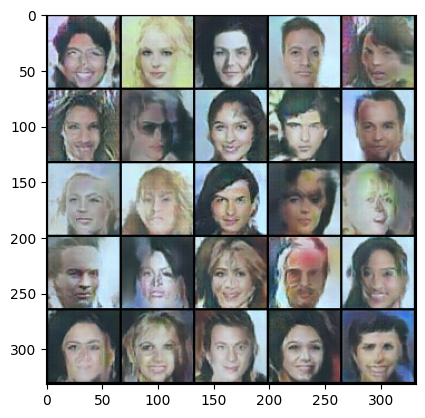

[Epoch 2/10] [Disc loss: -1044.9000244140625] [Gen loss: 74735.46875]


  0%|          | 0/1583 [00:00<?, ?it/s]

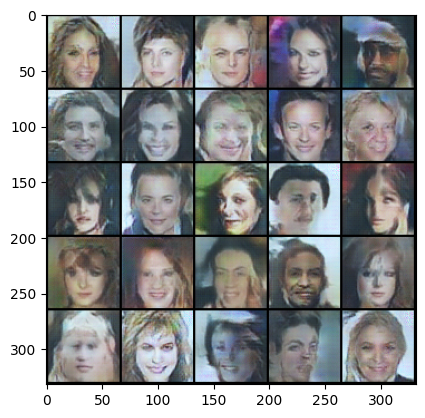

In [ ]:
from tqdm.auto import tqdm

import gc

for epoch in range(epochs):
    for batch, real in tqdm(enumerate(loader), total=len(loader)):
        cur_batch_size = len(real)
        real = real.to(device)

        # Update discriminator
        disc_optimizer.zero_grad()
        fake_noise = get_noise(cur_batch_size, z_dim)
        fake = generator(fake_noise)

        disc_fake_pred = discriminator(fake.detach())
        disc_real_pred = discriminator(real)

        epsilon = torch.rand((len(real), 1, 1, 1), device=device, requires_grad=True)
        gp = gradient_penalty(discriminator, real, fake.detach(), epsilon)

        disc_loss = -torch.mean(disc_real_pred) + torch.mean(disc_fake_pred) + c_lambda * gp

        disc_loss.backward()
        torch.nn.utils.clip_grad_norm_(discriminator.parameters(), max_norm=1.0)
        disc_optimizer.step()

        # Update generator
        if batch % crit_iters == 0:
            gen_optimizer.zero_grad()
            fake2 = generator(fake_noise)
            gen_fake_pred = discriminator(fake2)
            gen_loss = -torch.mean(gen_fake_pred)

            gen_loss.backward()
            torch.nn.utils.clip_grad_norm_(generator.parameters(), max_norm=1.0)
            gen_optimizer.step()

        if batch % (100 * crit_iters) == 0:
            with torch.no_grad():
                show_tensor_images(fake2)

        torch.cuda.empty_cache()
        gc.collect()

    print(f"[Epoch {epoch+1}/{epochs}] [Disc loss: {disc_loss.item()}] [Gen loss: {gen_loss.item()}]")
    torch.save(discriminator.state_dict(), f'discriminatorы_epoch{epoch}.pth')
    torch.save(generator.state_dict(), f'generatorы_epoch{epoch}.pth')

    with torch.no_grad():
        show_tensor_images(fake2)

# Итог

Закончили обучение WGAN'a. Ниже приведу несколько примеров относительно удачных лиц

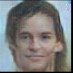
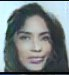


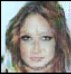
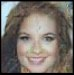
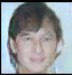

